<a href="https://colab.research.google.com/github/Arnava-03/prml_object_recognition/blob/main/object_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## **Data Preprocessing**

### LOADING THE DATASET

Reference of the dataset : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf  
Dataset and methodology followed is decribed in greater detail in the above cited link.


In [ ]:
# we will load the cifar10 dataset from keras
# reference : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
# dataset and methodology followed is decribed in greater detail in the above cited link.
from keras.datasets import cifar10

(X_train, y_train),(X_test, y_test) = cifar10.load_data()


ABOUT THE DATASET -


*   The dataset has 50000 training samples and 10000 test samples
*   cifar10 implies 10 class labels (or target labels)
*   Each sample has the shape (32,32,3)
*   Pixels in 32X32 images are indexed in values of three channels of Red, Blue and Green



In [ ]:
print(f'Shape of the training set (features): {X_train.shape}')
print(f'Shape of the training set (target): {y_train.shape}')
print(f'Shape of the test set (features): {X_test.shape}')
print(f'Shape of the test set (target): {y_test.shape}')


Shape of the training set (features): (50000, 32, 32, 3)
Shape of the training set (target): (50000, 1)
Shape of the test set (features): (10000, 32, 32, 3)
Shape of the test set (target): (10000, 1)


### Visualizing the image set

Text(0.5, 1.0, 'A single image')

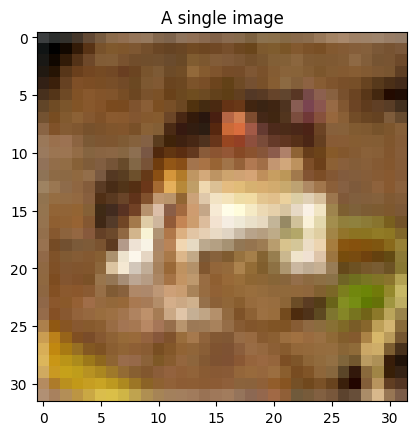

In [ ]:
#plotting the first sample of the trainging set
plt.imshow(X_train[0])
plt.title('A single image')

In [ ]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


The target set contains integer class labels representing one of the ten classes in the CIFAR-10 dataset.



In [ ]:
# These are the classnames in the dataset in the order
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


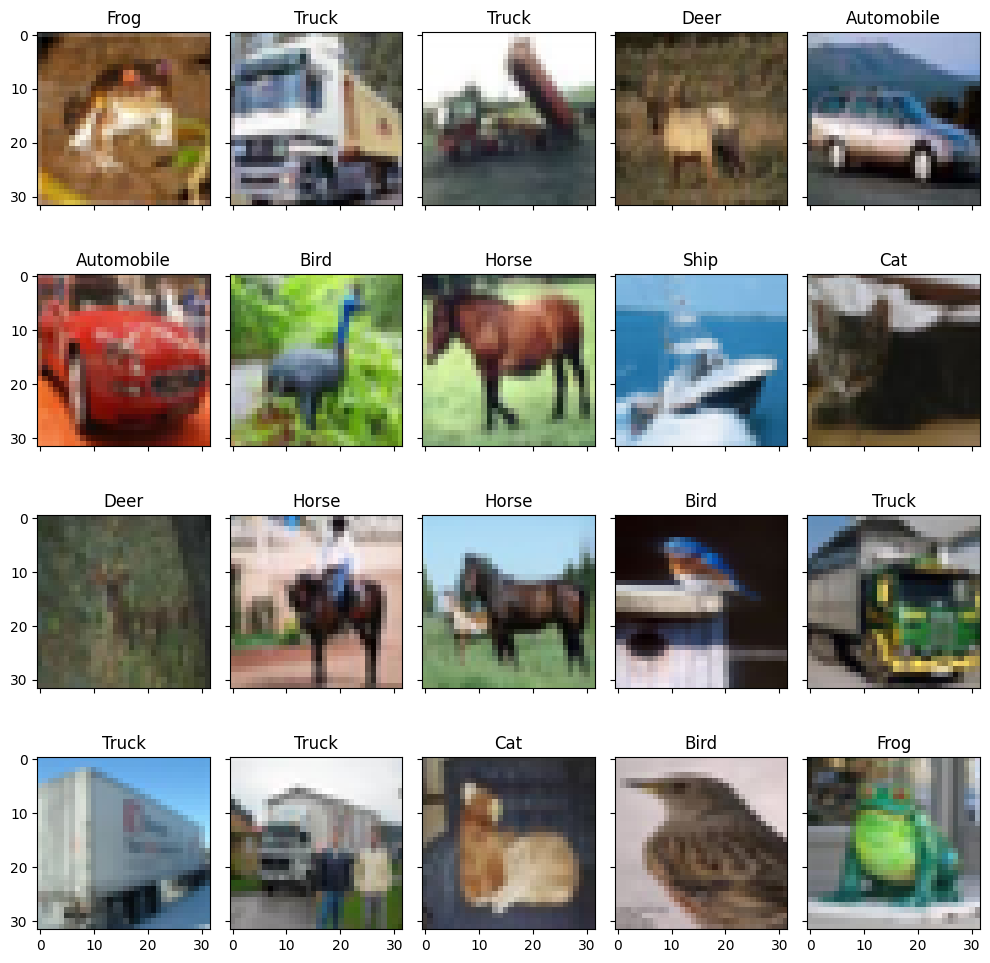

In [ ]:
#making a subplot of first few images

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(X_train[i])
  ax.set_title(class_names[y_train[i][0]])

plt.tight_layout()
plt.show()

Data Normalisation

In [ ]:
# Flattening the features array
# Flattening is typically done as traditional ml models require input in 2-d format
# more on the 2-d format - each row represents a single sample (image) and each column represents a feature (pixel).
print(f"here is X_train's shape before Flattening \n{X_train.shape}")
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"here is X_train's shape after Flattening \n{X_train_flat.shape}")
# As the pixel values in rgb channel of feature set range from 0-255 we are scaling it down to 0.0-1.0

min_value = np.min(X_train_flat)
max_value = np.max(X_train_flat)
# Perform min-max normalization
X_train_normalized = (X_train_flat - min_value) / (max_value - min_value)
X_test_normalized = (X_test_flat - min_value) / (max_value - min_value)

here is X_train's shape before Flattening 
(50000, 32, 32, 3)
here is X_train's shape after Flattening 
(50000, 3072)


In [ ]:
print(f'here is the y_train before Flattening : \n',y_train)
print(f'here is the shape of y_train before Flattening : ',y_train.shape)


# Flatten target labels
y_train = np.ravel(y_train)
print(f"\nhere is y_train after Flattening \n{y_train} \n and it's shape after Flattening\n{y_train.shape}")

print('\nsimilar process is for y_test')
y_test = np.ravel(y_test)

here is the y_train before Flattening : 
 [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
here is the shape of y_train before Flattening :  (50000, 1)

here is y_train after Flattening 
[6 9 9 ... 9 1 1] 
 and it's shape after Flattening
(50000,)

similar process is for y_test


## **Testing some classical machine learning models**

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train_normalized, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_normalized)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)


Accuracy of KNN: 0.3398
Precision of KNN: 0.4304261825528496
Recall of KNN: 0.3398
F1 Score of KNN: 0.3260170986061005


### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_normalized, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_normalized)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)


Accuracy of Decision Tree Classifier: 0.2673
Precision of Decision Tree Classifier: 0.26707661022836243
Recall of Decision Tree Classifier: 0.2673
F1 Score of Decision Tree Classifier: 0.2670368477968029


### Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_normalized, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_normalized)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.4725
Precision of Random Forest Classifier: 0.46822660166058794
Recall of Random Forest Classifier: 0.4725
F1 Score of Random Forest Classifier: 0.4686901305308043


### Naive bayes classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB


In [ ]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_normalized, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_normalized)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.2976
Precision of Naive Bayes Classifier: 0.31121406674181173
Recall of Naive Bayes Classifier: 0.2976
F1 Score of Naive Bayes Classifier: 0.27546278386551976


Now we are performing the LDA on dataset so that classes gets max spreted which we want and we get betteer results

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=9)  # Adjust the number of components as per requirement
X_train_lda = lda.fit_transform(X_train_normalized, y_train)
X_test_lda = lda.transform(X_test_normalized)

# KNN Classifier
knn = KNeighborsClassifier()
knn.fit(X_train_lda, y_train)
y_pred_knn = knn.predict(X_test_lda)

# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train_lda, y_train)
y_pred_dt = dt.predict(X_test_lda)

# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_lda, y_train)
y_pred_rf = rf.predict(X_test_lda)

# Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train_lda, y_train)
y_pred_nb = nb.predict(X_test_lda)

# Evaluate models
print("K-Nearest Neighbors:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_knn, average='weighted'))

print("\nDecision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))

print("\nNaive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))


K-Nearest Neighbors:
Accuracy: 0.3295
Precision: 0.334759002512748
Recall: 0.3295

Decision Tree:
Accuracy: 0.2746
Precision: 0.27450245196799367
Recall: 0.2746

Random Forest:
Accuracy: 0.3717
Precision: 0.3701285794589169
Recall: 0.3717

Naive Bayes:
Accuracy: 0.3659
Precision: 0.36613766941467
Recall: 0.3659


## Performing PCA

In [ ]:
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=0.95)  # retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

n_components_chosen = pca.n_components_
print("Number of components chosen:", n_components_chosen)

Number of components chosen: 217


### KNN

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
# Train the classifier
knn_classifier.fit(X_train_pca, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.3625
Precision of KNN: 0.4466677313172691
Recall of KNN: 0.3625
F1 Score of KNN: 0.354497969454903


### Decision Tree

In [ ]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_pca, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test_pca)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.2589
Precision of Decision Tree Classifier: 0.2589049176115985
Recall of Decision Tree Classifier: 0.2589
F1 Score of Decision Tree Classifier: 0.2587282417515696


### Random Forset

In [ ]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_pca, y_train)

y_pred_random_forest = random_forest_model.predict(X_test_pca)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

Accuracy of Random Forest Classifier: 0.4365
Precision of Random Forest Classifier: 0.43245711819164034
Recall of Random Forest Classifier: 0.4365
F1 Score of Random Forest Classifier: 0.4326432236045719


### Naive Bayes

In [ ]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_pca, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test_pca)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

Accuracy of Naive Bayes Classifier: 0.3122
Precision of Naive Bayes Classifier: 0.33380316708946484
Recall of Naive Bayes Classifier: 0.3122
F1 Score of Naive Bayes Classifier: 0.29941025377966646


## Feature Extraction and Tuning parameters

### ResNet Features

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
# Calculate mean and standard deviation
mean_data = np.mean(X_train, axis=(0, 1, 2)) / 255
std_data = np.std(X_train, axis=(0, 1, 2)) / 255

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_data, std=std_data),
    ])
# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# resnet = models.resnet50(weights='imagenet')

# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()
all_features = []
X_train_features = []
for image_data in X_train:
    image = Image.fromarray(image_data)  #Converting to type PIL.Image
    image = preprocess(image)
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = resnet(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    all_features.append(features.numpy())
    X_train_features.append(features.numpy())

X_test_features = []
for image_data in X_test:
    image = Image.fromarray(image_data)  #Converting to type PIL.Image
    image = preprocess(image)
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = resnet(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    all_features.append(features.numpy())
    X_test_features.append(features.numpy())

# all_features_tensor = torch.tensor(all_features)
all_features_array = np.array(all_features)
all_features_tensor = torch.tensor(all_features_array)
# Save the extracted features to a file
torch.save(all_features_tensor, 'extracted_features.pt')

In [ ]:
print(all_features_tensor.shape)

torch.Size([60000, 2048, 1, 1])


Loading the saved features and selecting the training data and testing data

In [ ]:
# Load the saved features from the file
loaded_features = torch.load('extracted_features.pt')
X_train_features = loaded_features[:50000]
X_test_features = loaded_features[50000:]

In [ ]:
print(X_train.shape)
# Changing the shape
X_train = np.array(X_train_features).reshape(X_train.shape[0], -1)
X_test = np.array(X_test_features).reshape(X_test.shape[0], -1)


(50000, 32, 32, 3)


### KNN

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.8408
Precision of KNN: 0.8449391444512696
Recall of KNN: 0.8408
F1 Score of KNN: 0.840755764730697


Finding optimum value of 'k'

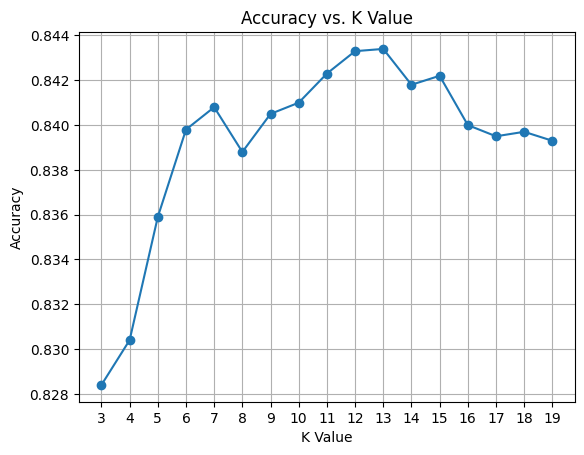

Best value of k: 13


In [ ]:
import matplotlib.pyplot as plt

# Define a range of k values to try
k_values = range(3, 20)  # You can adjust the range as needed

# Initialize lists to store accuracies for each k
accuracies = []

# Iterate over each value of k
for k in k_values:
    # Create and train the KNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)

    # Predict labels for the validation set
    y_pred = knn_classifier.predict(X_test)

    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot k versus accuracy
plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Find the k value with the highest accuracy
best_k = k_values[accuracies.index(max(accuracies))]
print("Best value of k:", best_k)


In [ ]:
#using the best value of k
knn_classifier = KNeighborsClassifier(n_neighbors=13)

# Train the classifier
knn_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)

Accuracy of KNN: 0.8434
Precision of KNN: 0.848380873014827
Recall of KNN: 0.8434
F1 Score of KNN: 0.8432689748734811


Finding inaccuracies

Misclassifications count per class:
Class 6: 99 misclassifications
Class 5: 238 misclassifications
Class 7: 169 misclassifications
Class 4: 178 misclassifications
Class 1: 76 misclassifications
Class 3: 211 misclassifications
Class 2: 291 misclassifications
Class 0: 145 misclassifications
Class 9: 96 misclassifications
Class 8: 63 misclassifications


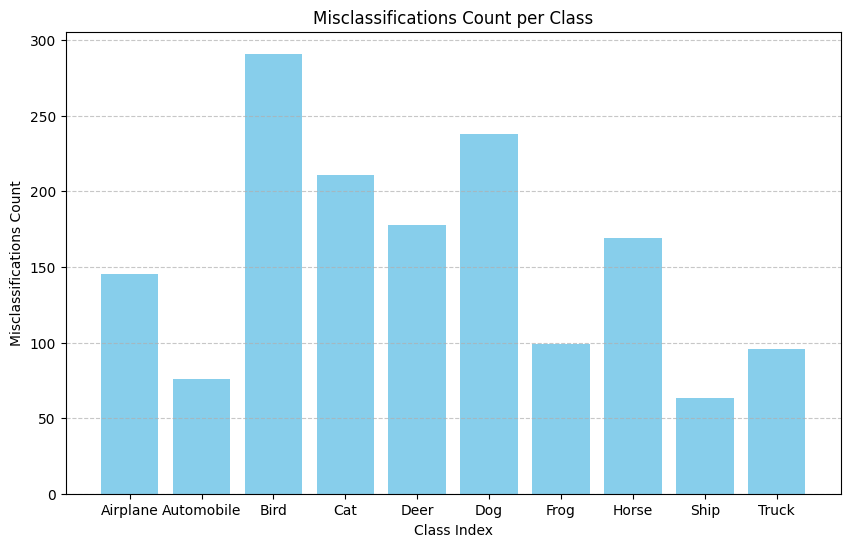

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Create a dictionary to store misclassifications count for each class
misclassifications_count = defaultdict(int)

# Iterate through the test set and count misclassifications
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        misclassifications_count[true_label] += 1

# Print misclassifications count for each class
print("Misclassifications count per class:")
for class_index, count in misclassifications_count.items():
    print(f"Class {class_index}: {count} misclassifications")

# Visualize misclassifications
# Convert misclassifications count dictionary to lists for plotting
classes = list(misclassifications_count.keys())
misclassifications = [misclassifications_count[i] for i in range(len(class_names))]

# Plot misclassifications count for each class using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, misclassifications, color='skyblue')
plt.title('Misclassifications Count per Class')
plt.xlabel('Class Index')
plt.ylabel('Misclassifications Count')
plt.xticks(classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


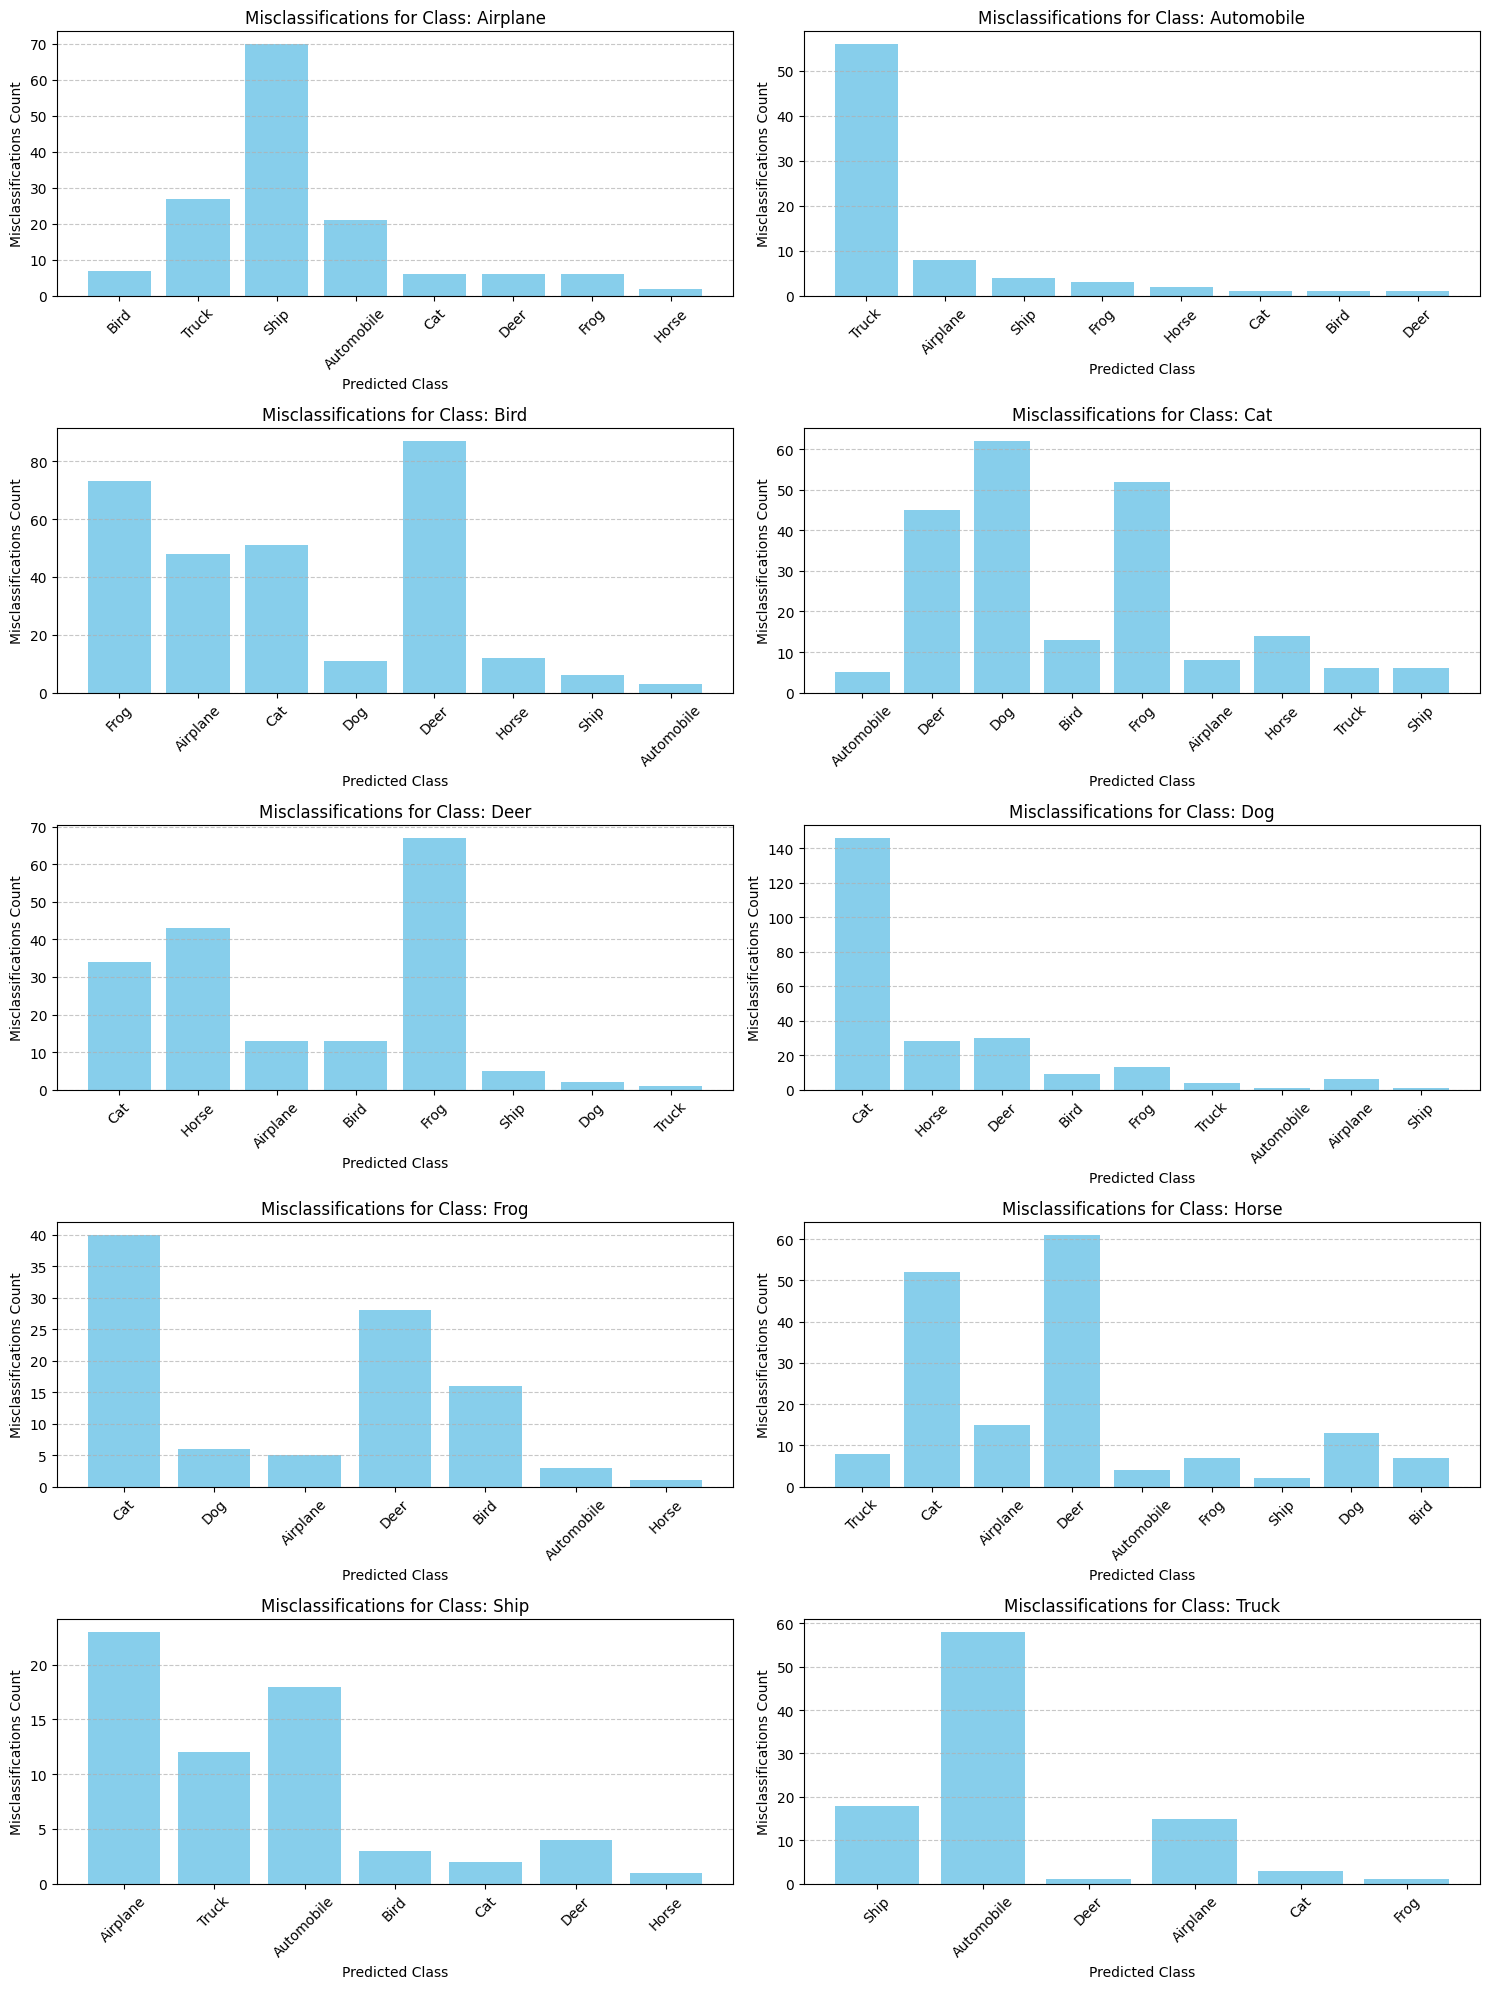

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Create a dictionary to store misclassifications count for each class
misclassifications_count_per_class = {class_name: defaultdict(int) for class_name in class_names}

# Iterate through the test set and count misclassifications per class
for true_label, predicted_label in zip(y_test, y_pred):
    if true_label != predicted_label:
        true_class_name = class_names[true_label]
        predicted_class_name = class_names[predicted_label]
        misclassifications_count_per_class[true_class_name][predicted_class_name] += 1

# Plot misclassifications count for each class using a single plot with multiple subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i, class_name in enumerate(class_names):
    # Get misclassification counts for the current class
    misclassifications = misclassifications_count_per_class[class_name]

    # Convert misclassification counts dictionary to lists for plotting
    predicted_classes = list(misclassifications.keys())
    counts = list(misclassifications.values())

    # Plot the bar chart
    ax = axs[i // 2, i % 2]
    ax.bar(predicted_classes, counts, color='skyblue')
    ax.set_title(f'Misclassifications for Class: {class_name}')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Misclassifications Count')
    ax.set_xticks(range(len(predicted_classes)))  # Set the tick positions
    ax.set_xticklabels(predicted_classes, rotation=45)  # Set the tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Decision Tree

In [ ]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(X_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)

Accuracy of Decision Tree Classifier: 0.6491
Precision of Decision Tree Classifier: 0.6497217108541726
Recall of Decision Tree Classifier: 0.6491
F1 Score of Decision Tree Classifier: 0.6493488794437652


### Random Forest

In [ ]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred_random_forest = random_forest_model.predict(X_test)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy of Random Forest Classifier: 0.8303
Precision of Random Forest Classifier: 0.8314508457870179
Recall of Random Forest Classifier: 0.8303
F1 Score of Random Forest Classifier: 0.8302876230176884


### Naive Bayes

In [ ]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(X_test)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Naive Bayes Classifier: 0.7948
Precision of Naive Bayes Classifier: 0.797058885568306
Recall of Naive Bayes Classifier: 0.7948
F1 Score of Naive Bayes Classifier: 0.794656614631248


## HoG Features

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt

In [ ]:

def compute_hog(img):
    # Resize the image while preserving aspect ratio
    resized_img = resize(img, (32, 32))
    # Compute HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd

# Concatenate the X_test and X_train arrays
all_images = np.concatenate((X_train, X_test), axis=0)

# Compute HOG features for all images in the concatenated dataset
all_hog_features = []
for img in all_images:
    hog_features = compute_hog(img)
    all_hog_features.append(hog_features)

# Convert the list of HOG features to a numpy array
all_hog_features = np.array(all_hog_features)

# Separate the HOG features for testing and training images
num_train_images = len(X_train)
all_hog_features_train = all_hog_features[:num_train_images]
all_hog_features_test = all_hog_features[num_train_images:]

# Save the numpy arrays containing all HOG features to a file
np.savez('cifar10_hog_features.npz', X_train=all_hog_features_train, X_test=all_hog_features_test)



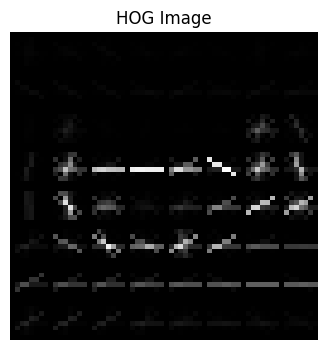

Text(0.5, 1.0, 'Original Image')

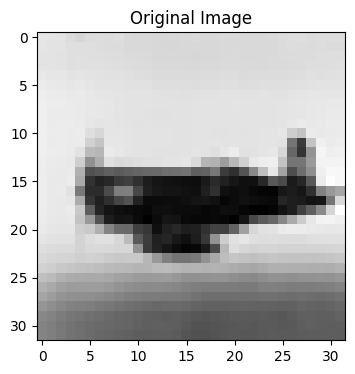

In [ ]:
def compute_hog(img):
    # Resize the image while preserving aspect ratio
    resized_img = resize(img, (64, 64))
    # Compute HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

# Read an example image
Hog_feature, hog_image = compute_hog(X_train[115])

# Plot the HOG image
plt.figure(figsize=(8, 4))
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')
plt.axis('off')
plt.show()
plt.figure(figsize=(8, 4))
plt.imshow(X_train[115])
plt.title("Original Image")

Now applying the previously trained classical ML models, to check classification and comparing performance.


#### KNN


In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=8)
# Train the classifier
knn_classifier.fit(all_hog_features_train, y_train)

# Predict labels for test set
y_pred = knn_classifier.predict(all_hog_features_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy of KNN:", accuracy)
print("Precision of KNN:", precision)
print("Recall of KNN:", recall)
print("F1 Score of KNN:", f1)


c:\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of KNN: 0.5235
Precision of KNN: 0.5721330502598757
Recall of KNN: 0.5235
F1 Score of KNN: 0.5180642025224663


#### Decision Tree

In [ ]:
# Train Decision Tree classifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(all_hog_features_train, y_train)

# Predict labels for test set
y_pred_decision_tree = decision_tree_model.predict(all_hog_features_test)

accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree, average='weighted')
recall_decision_tree = recall_score(y_test, y_pred_decision_tree, average='weighted')
f1_decision_tree = f1_score(y_test, y_pred_decision_tree, average='weighted')

print("Accuracy of Decision Tree Classifier:", accuracy_decision_tree)
print("Precision of Decision Tree Classifier:", precision_decision_tree)
print("Recall of Decision Tree Classifier:", recall_decision_tree)
print("F1 Score of Decision Tree Classifier:", f1_decision_tree)


Accuracy of Decision Tree Classifier: 0.279
Precision of Decision Tree Classifier: 0.28048685243083243
Recall of Decision Tree Classifier: 0.279
F1 Score of Decision Tree Classifier: 0.27966954478574946


#### Random Forest Classifier

In [ ]:
# Train Random Forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(all_hog_features_train, y_train)

y_pred_random_forest = random_forest_model.predict(all_hog_features_test)


accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
precision_random_forest = precision_score(y_test, y_pred_random_forest, average='weighted')
recall_random_forest = recall_score(y_test, y_pred_random_forest, average='weighted')
f1_random_forest = f1_score(y_test, y_pred_random_forest, average='weighted')

print("Accuracy of Random Forest Classifier:", accuracy_random_forest)
print("Precision of Random Forest Classifier:", precision_random_forest)
print("Recall of Random Forest Classifier:", recall_random_forest)
print("F1 Score of Random Forest Classifier:", f1_random_forest)

c:\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy of Random Forest Classifier: 0.525
Precision of Random Forest Classifier: 0.521646415382805
Recall of Random Forest Classifier: 0.525
F1 Score of Random Forest Classifier: 0.5204869780514788


#### Naive Bayes Classifier

In [ ]:
# Train Naive Bayes classifier
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(all_hog_features_train, y_train)

y_pred_naive_bayes = naive_bayes_model.predict(all_hog_features_test)

accuracy_naive_bayes = accuracy_score(y_test, y_pred_naive_bayes)
precision_naive_bayes = precision_score(y_test, y_pred_naive_bayes, average='weighted')
recall_naive_bayes = recall_score(y_test, y_pred_naive_bayes, average='weighted')
f1_naive_bayes = f1_score(y_test, y_pred_naive_bayes, average='weighted')

print("Accuracy of Naive Bayes Classifier:", accuracy_naive_bayes)
print("Precision of Naive Bayes Classifier:", precision_naive_bayes)
print("Recall of Naive Bayes Classifier:", recall_naive_bayes)
print("F1 Score of Naive Bayes Classifier:", f1_naive_bayes)

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Naive Bayes Classifier: 0.4581
Precision of Naive Bayes Classifier: 0.4667085487081605
Recall of Naive Bayes Classifier: 0.4581
F1 Score of Naive Bayes Classifier: 0.4536907851130096
